In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

# Pipeline

In [90]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
df.sample()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
424,8,151,78,32,210,42.9,0.516,36,1


# Step 0. Binarize the data

In [163]:
gb = df.groupby('binGl')['Outcome'].mean()
df_sample = pd.DataFrame(columns=df.columns)
need_to_choose = set(gb.index.unique())

for i in range(df.shape[0]):
  if df.iloc[i]['binGl'] not in need_to_choose:
    continue
  
  if df.iloc[i]['Outcome'] == np.round(gb[df.iloc[i]['binGl']]):
    df_sample = df_sample.append(df.iloc[i])
    need_to_choose.remove(df.iloc[i]['binGl'])
df_sample = df_sample.reset_index()

In [200]:
df_bin = pd.DataFrame()
df_bin['=0'] = df['Glucose'] == 0
step = 8
for i in range(40, 200, step):
  df_bin['('+str(i) + ';' + str(i+step) + ']'] = (df['Glucose'] >i ) & (df['Glucose'] <= (i+step))


df_bin['Outcome'] = df['Outcome'] == 1

In [195]:
df_bin.shape

(768, 12)

In [201]:

df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,=0,(40;48],(48;56],(56;64],(64;72],(72;80],(80;88],(88;96],(96;104],(104;112],...,(128;136],(136;144],(144;152],(152;160],(160;168],(168;176],(176;184],(184;192],(192;200],Outcome
id,,,,,,,,,,,,,,,,,,,,,
h379,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


Split the data to train and test

In [202]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]
X_train.sample()



,=0,(40;48],(48;56],(56;64],(64;72],(72;80],(80;88],(88;96],(96;104],(104;112],...,(120;128],(128;136],(136;144],(144;152],(152;160],(160;168],(168;176],(176;184],(184;192],(192;200]
id,,,,,,,,,,,,,,,,,,,,,
h539,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [203]:
%%time 
K_train = FormalContext.from_pandas(X_train)
K_train

CPU times: user 2.67 ms, sys: 0 ns, total: 2.67 ms
Wall time: 2.68 ms


FormalContext (537 objects, 21 attributes, 537 connections)
    |=0|(40;48]|(48;56]|(56;64]|(64;72]|...|(160;168]|(168;176]|(176;184]|(184;192]|(192;200]|
h580|  |       |       |       |       |...|         |         |         |         |         |
h418|  |       |       |       |       |...|         |         |         |         |         |
h764|  |       |       |       |       |...|         |         |         |         |         |
h363|  |       |       |       |       |...|         |         |         |         |         |
h757|  |       |       |       |       |...|         |         |         |         |         |
h636|  |       |       |       |       |...|         |         |         |         |         |
h155|  |       |       |       |       |...|         |         |         |         |         |
h390|  |       |       |       |       |...|         |         |         |         |         |
h761|  |       |       |       |       |...|         |        X|         |         | 

In [204]:
%%time 

L = ConceptLattice.from_context(K_train,algo='Sofia', is_monotone=True)
len(L)

CPU times: user 1min 2s, sys: 236 ms, total: 1min 2s
Wall time: 1min 2s


98

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [205]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [210]:
n_concepts = 4
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [228]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [212]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [ ]:
'''
vis.init_mover_per_poset(cn.poset)
mvr = vis.mover
for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
    mvr.swap_nodes(a, b)
    
for nodes, vert in [
    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
]:
    for a in nodes:
        mvr.place_node(a, mvr.posx[vert])
'''

In [213]:
set(X_train.columns)

{'(104;112]',
 '(112;120]',
 '(120;128]',
 '(128;136]',
 '(136;144]',
 '(144;152]',
 '(152;160]',
 '(160;168]',
 '(168;176]',
 '(176;184]',
 '(184;192]',
 '(192;200]',
 '(40;48]',
 '(48;56]',
 '(56;64]',
 '(64;72]',
 '(72;80]',
 '(80;88]',
 '(88;96]',
 '(96;104]',
 '=0'}

In [216]:
descr = {'(184;192]'}

traced = cn.trace_description(descr, include_targets=False)

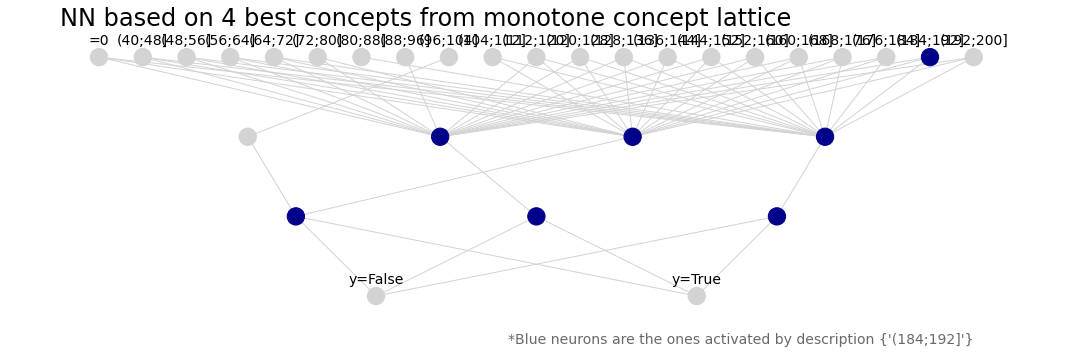

In [239]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on '+str(n_concepts)+' best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_glucose.png')
plt.show()

Now fit the network

In [229]:
cn.fit(X_train, y_train,  n_epochs = 2000)

To obtain the prediction

In [230]:
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[3.7926584e-02 9.6207345e-01]
 [9.9983466e-01 1.6534647e-04]
 [9.9989843e-01 1.0153712e-04]
 [3.7926584e-02 9.6207345e-01]
 [9.9983466e-01 1.6534647e-04]
 [9.9510902e-01 4.8910147e-03]
 [2.7033290e-01 7.2966713e-01]
 [1.6953969e-02 9.8304605e-01]
 [7.0982808e-01 2.9017189e-01]
 [9.9510789e-01 4.8920955e-03]]
True class [ True False False  True False False  True  True False False]


Check our metrics

In [231]:
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))

Recall score: 0.3783783783783784
F1     score: 0.4745762711864407


Let's also check accuracy and classification report

In [232]:
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Accuracy score: 0.7316017316017316


In [233]:
print(classification_report(y_test.values.astype('int'), y_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       157
           1       0.64      0.38      0.47        74

    accuracy                           0.73       231
   macro avg       0.70      0.64      0.65       231
weighted avg       0.72      0.73      0.71       231



Let's at least test it on train data

In [234]:
y_pred = cn.predict(X_train).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_train).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_train.values[:10])

Class prediction [1 0 0 1 0 0 1 0 1 0]
Class prediction with probabilities [[0.2703329  0.7296671 ]
 [0.995109   0.00489101]
 [0.7098281  0.2901719 ]
 [0.2703329  0.7296671 ]
 [0.7098281  0.2901719 ]
 [0.9951079  0.0048921 ]
 [0.2703329  0.7296671 ]
 [0.9951079  0.0048921 ]
 [0.01695397 0.98304605]
 [0.995109   0.00489101]]
True class [ True False False  True  True False  True False  True False]


In [235]:
print('Recall score:', recall_score(y_train.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_train.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_train.values.astype('int'), y_pred))

Recall score: 0.4845360824742268
F1     score: 0.5893416927899686
Accuracy score: 0.7560521415270018


In [236]:
edge_weights = cn.edge_weights_from_network()

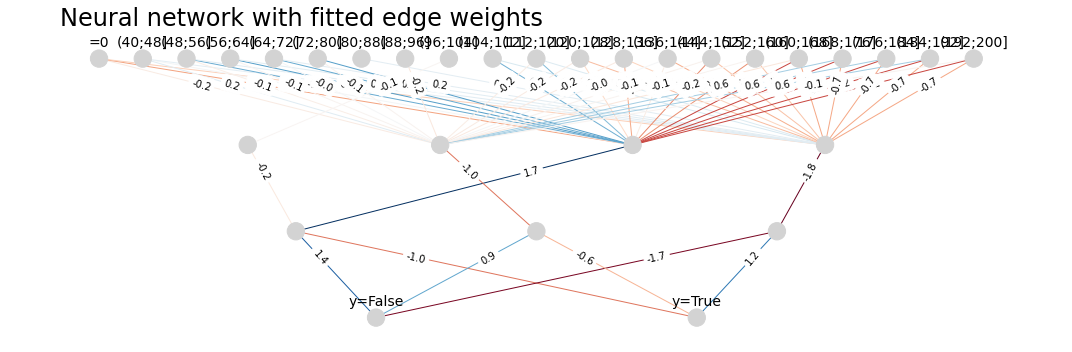

In [238]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network_glucose.png')
plt.show()